필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
scb_yearly = pd.read_excel(base_path+"Seungchonbo.xlsx", 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(scb_yearly))  # type-dict
print(scb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
scb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
scb_yearly_df13 = pd.DataFrame()

for item in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[item]])

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


In [12]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

In [13]:
scb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01h,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02h,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03h,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04h,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9


유량 데이터 추가하기

In [14]:
scb_flow_yearly = pd.read_excel(base_path+"Seungchonbo_flow.xlsx", 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['연월일시'] = scb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [18]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [19]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(scb_flow_yearly_hour_df.__len__())
print(scb_yearly_df13.__len__())

84393
82257


In [21]:
scb_yearly_df13['연월일시'] = scb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [23]:
scb_data = scb_data[:82257]

In [24]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11   상류수위(EL.m)  82231 non-null  float64
 12   하류수위(EL.m)  82231 non-null  float64
 13   유입량(㎥/s)    82231 non-null  float64
 14   방류량(㎥/s)    82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [25]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [26]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11  상류수위(EL.m)   82231 non-null  float64
 12  하류수위(EL.m)   82231 non-null  float64
 13  유입량(㎥/s)     82231 non-null  float64
 14  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [27]:
scb_data = scb_data.loc[:, list(scb_data.columns)[:3]  + list(scb_data.columns)[4:5] + list(scb_data.columns)[6:-5] + list(scb_data.columns)[-4:-3] + list(scb_data.columns)[-1:]]

In [28]:
scb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
scb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
dtype: int64

In [30]:
scb_data.isnull().sum() /len(scb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

In [31]:
len(scb_data)

82257

시간데이터 추가

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for var in col_c[2:]:
    for i in range(1, 73):
        scb_df[str(i) + 'shift' + var] = scb_df[var].shift(i)

/tmp/ipykernel_16617/928123686.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  scb_df[str(i) + 'shift' + var] = scb_df[var].shift(i)


In [37]:
len(scb_df)

82257

In [38]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=514)

In [39]:
len(scb_df)

82257

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
scb_df = scb_df.copy()

In [42]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
scb_df = scb_df.dropna()

In [45]:
scb_df.__len__()

80082

In [46]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=513)

In [47]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),1shift수온 ℃,...,63shift방류량(㎥/s),64shift방류량(㎥/s),65shift방류량(㎥/s),66shift방류량(㎥/s),67shift방류량(㎥/s),68shift방류량(㎥/s),69shift방류량(㎥/s),70shift방류량(㎥/s),71shift방류량(㎥/s),72shift방류량(㎥/s)
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-04-01 16:00:00,용봉,14.0,337.0,3.45,7.083,0.110,40.85,7.520000,3.980000,14.0,...,14.436667,14.496667,14.503333,14.551667,14.580000,14.615000,15.346667,15.973333,13.275000,12.343333
2013-04-01 17:00:00,용봉,14.0,340.0,3.50,7.077,0.109,45.80,7.528333,4.993333,14.0,...,14.415000,14.436667,14.496667,14.503333,14.551667,14.580000,14.615000,15.346667,15.973333,13.275000
2013-04-01 18:00:00,용봉,13.9,341.0,3.50,7.100,0.107,46.10,7.535000,13.198333,14.0,...,14.335000,14.415000,14.436667,14.496667,14.503333,14.551667,14.580000,14.615000,15.346667,15.973333
2013-04-01 19:00:00,용봉,13.7,345.0,3.40,7.203,0.106,47.00,7.540000,14.970000,13.9,...,14.330000,14.335000,14.415000,14.436667,14.496667,14.503333,14.551667,14.580000,14.615000,15.346667
2013-04-01 20:00:00,용봉,13.7,353.0,3.50,7.108,0.105,45.20,7.540000,14.971667,13.7,...,14.315000,14.330000,14.335000,14.415000,14.436667,14.496667,14.503333,14.551667,14.580000,14.615000


In [48]:
col = list(scb_df.columns[1:])
#print(col)

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.774 total time=12.7min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.780 total time=12.6min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.769 total time=12.5min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.947 total time=24.5min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.949 total time=24.6min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.947 total time=24.3min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=34.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.964 total time=34.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.959 total time=35.0min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.829 total time=12.8min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.835 total time=12.8min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.962453,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.961944,2
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.960683,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.958685,4
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.958588,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.02 수온 ℃
0.11 전기전도도 μS/cm
0.0 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.05 상류수위(EL.m)
0.0 방류량(㎥/s)
0.01 1shift수온 ℃
0.06 2shift수온 ℃
0.01 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.01 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.0 32shift수온 ℃
0.0 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.0 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.0 43shift수온 ℃
0.0 44shift수온 ℃
0.0 45shift수온 ℃
0.0 46shift수온 ℃
0.0 47shift수온 ℃
0.0 48shift수온 ℃
0.0 49shift수온 ℃
0.0 50shift수온 ℃
0.0 51shift수온 ℃
0.0 52shift수온 ℃
0.0 53shift수온 ℃
0.0 54shift수온 ℃
0.0 55shift수온 ℃
0.0 56shift수온 ℃
0.0 57shift

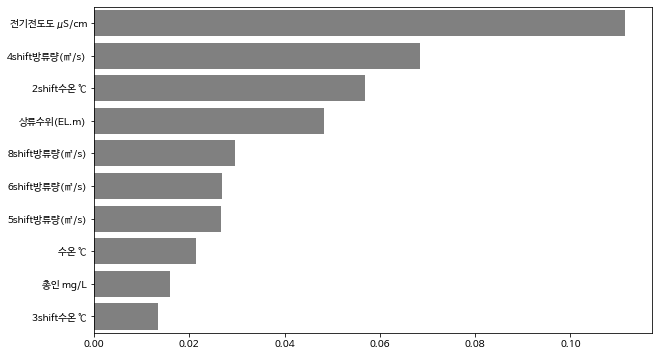

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
feature_series[:10]

전기전도도 μS/cm       0.111522
4shift방류량(㎥/s)    0.068444
2shift수온 ℃        0.056919
상류수위(EL.m)        0.048258
8shift방류량(㎥/s)    0.029667
6shift방류량(㎥/s)    0.026824
5shift방류량(㎥/s)    0.026765
수온 ℃              0.021480
총인 mg/L           0.015860
3shift수온 ℃        0.013525
dtype: float64

In [61]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.978502249142259


피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [63]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift수온 ℃,2shift수온 ℃,3shift수온 ℃,...,63shift방류량(㎥/s),64shift방류량(㎥/s),65shift방류량(㎥/s),66shift방류량(㎥/s),67shift방류량(㎥/s),68shift방류량(㎥/s),69shift방류량(㎥/s),70shift방류량(㎥/s),71shift방류량(㎥/s),72shift방류량(㎥/s)
0,-0.460245,-0.079644,-1.016651,0.820873,-0.287552,0.713008,-0.247190,-0.460233,-0.473285,-0.512471,...,-0.155588,-0.155063,-0.155005,-0.154581,-0.154333,-0.154027,-0.147617,-0.142127,-0.165767,-0.173929
1,-0.460245,-0.045608,-0.966339,0.817849,-0.302224,0.718423,-0.238312,-0.460233,-0.460217,-0.473267,...,-0.155778,-0.155588,-0.155063,-0.155005,-0.154581,-0.154333,-0.154027,-0.147617,-0.142127,-0.165767
2,-0.473313,-0.034263,-0.966339,0.829440,-0.331570,0.722755,-0.166431,-0.460233,-0.460217,-0.460199,...,-0.156479,-0.155778,-0.155589,-0.155063,-0.155005,-0.154582,-0.154334,-0.154027,-0.147617,-0.142127
3,-0.499448,0.011118,-1.066964,0.881345,-0.346242,0.726004,-0.150910,-0.473300,-0.460217,-0.460199,...,-0.156523,-0.156479,-0.155778,-0.155589,-0.155063,-0.155005,-0.154582,-0.154334,-0.154027,-0.147617
4,-0.499448,0.101881,-0.966339,0.833471,-0.360915,0.726004,-0.150896,-0.499436,-0.473285,-0.460199,...,-0.156654,-0.156523,-0.156479,-0.155779,-0.155589,-0.155063,-0.155005,-0.154582,-0.154334,-0.154027


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3, verbose=5)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.774 total time=12.4min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.780 total time=12.4min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.769 total time=12.5min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.947 total time=24.2min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.949 total time=24.1min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.946 total time=24.2min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=34.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.964 total time=33.9min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.959 total time=33.8min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.829 total time=12.5min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.835 total time=12.4min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.962334,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.961919,2
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.960336,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.958595,4
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.958504,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.02 수온 ℃
0.11 전기전도도 μS/cm
0.0 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.05 상류수위(EL.m)
0.0 방류량(㎥/s)
0.01 1shift수온 ℃
0.06 2shift수온 ℃
0.01 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.01 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.0 32shift수온 ℃
0.0 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.0 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.0 43shift수온 ℃
0.0 44shift수온 ℃
0.0 45shift수온 ℃
0.0 46shift수온 ℃
0.0 47shift수온 ℃
0.0 48shift수온 ℃
0.0 49shift수온 ℃
0.0 50shift수온 ℃
0.0 51shift수온 ℃
0.0 52shift수온 ℃
0.0 53shift수온 ℃
0.0 54shift수온 ℃
0.0 55shift수온 ℃
0.0 56shift수온 ℃
0.0 57shift

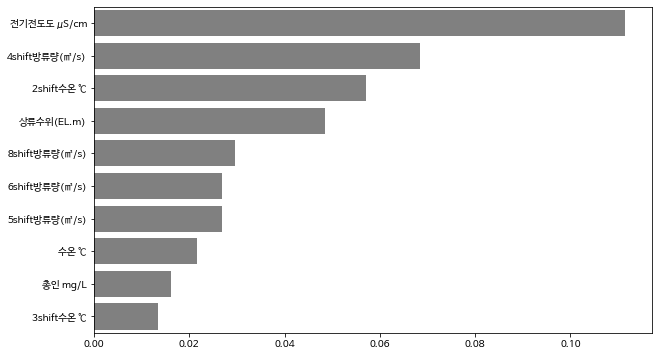

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
feature_seriess[:10]

전기전도도 μS/cm       0.111522
4shift방류량(㎥/s)    0.068481
2shift수온 ℃        0.057009
상류수위(EL.m)        0.048591
8shift방류량(㎥/s)    0.029632
6shift방류량(㎥/s)    0.026846
5shift방류량(㎥/s)    0.026775
수온 ℃              0.021557
총인 mg/L           0.016075
3shift수온 ℃        0.013502
dtype: float64

In [75]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9785188420387946
